Q.Modify and/or use the already existing functionality of PyAutoLens to simulate strong lensing from superfluid dark matter. Specifically, you will need to simulate the effects of lensing from a linear mass density - imagine this being a string of mass on galactic scales.

A.First of all, For simplicity, I am going to think the dark matter discussed in this task as axion. This is because axion is a representative of the dark matter with superfluidity, and is in the paper of DEEPLENSE project[1] .

In this task,
I will start with consideration from a linear mass density.  
According to pp.3[1], vortex solution is characterized by a density profile that can be parameterized below
$$
\rho_{v}(r, z)=\left\{\begin{array}{ll}0, & r>r_{v} \\ \rho_{v 0}\left[\left(\frac{r}{r_{v}}\right)^{\alpha_{v}}-1\right], & r \leq r_{v}\end{array}\right.
$$
This models the vortex as a tube. Therefore, we can use line integral to it and the vortex's mass can be calculated.

there're two ways in the aspect of implementation.  
First, I implement the dark matter halo as a spherical isothermal, like the related work[1] does. I use the parameter according to the paper.  
Second, I implement it using mass-sheet class, which is at PyAutoAstro project[2].  
In this case, according to [3], I calculate kappa(The magnitude of the convergence of the mass-sheet) in the equation below.   
(x: the distance from spectator to source plane, or lensed galaxy)  
(k: kappa)
$$
k(x) = 1/(2x) 
$$
I implement in both ways. (still working on the second method)
  
 ------ 
  
Reference:  
   
 [1] Deep Learning the Morphology of Dark Matter Substructure
 https://arxiv.org/abs/1909.07346
 
 [2] https://github.com/Jammy2211/PyAutoAstro/blob/master/autoastro/profiles/mass_profiles/mass_sheets.py
   
 [3] Introduction to Gravitational Lensing Lecture scripts, pp37,39,41
 http://www.ita.uni-heidelberg.de/~massimo/sub/Lectures/gl_all.pdf

In [9]:
%matplotlib inline

import autolens as al
import autolens.plot as aplt

grid = al.grid.uniform(shape_2d=(100, 100), pixel_scales=0.05, sub_size=2)

In [10]:
source_galaxy = al.Galaxy(
    redshift=1.0,
    bulge=al.lp.EllipticalSersic( #銀河の中央の膨らみ部分。核。
        centre=(0.1, 0.1),
        axis_ratio=0.8,
        phi=45.0,
        intensity=1.0,
        effective_radius=1.0,
        sersic_index=4.0, #銀河の観測面の表面の輝度分布。簡単にいうと、数字がでかい方が明るい銀河。
    ),
    disk=al.lp.EllipticalSersic( #銀河の外縁側。渦巻銀河等では腕があるところ。
        centre=(0.1, 0.1),
        axis_ratio=0.8,
        phi=45.0,
        intensity=1.0,
        effective_radius=1.0,
        sersic_index=1.0,
    ),
)

### Source galaxy (lensed galaxy)'s original image

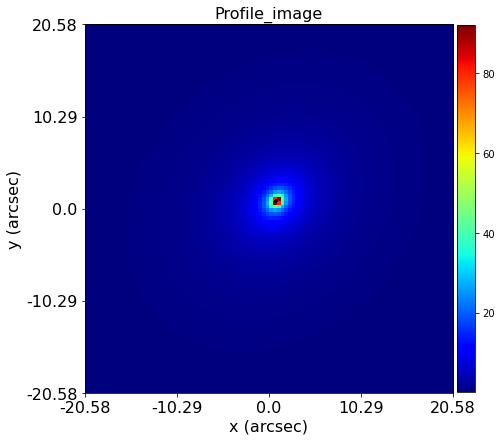

In [18]:
aplt.galaxy.profile_image(
    galaxy=source_galaxy, grid=grid
)

### First method

In [11]:
lens_galaxy = al.Galaxy(
    redshift=0.5,
    mass=al.mp.SphericalIsothermal(
        centre=(0.0, 0.0), einstein_radius=1.2
    ),
)

In [12]:
tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

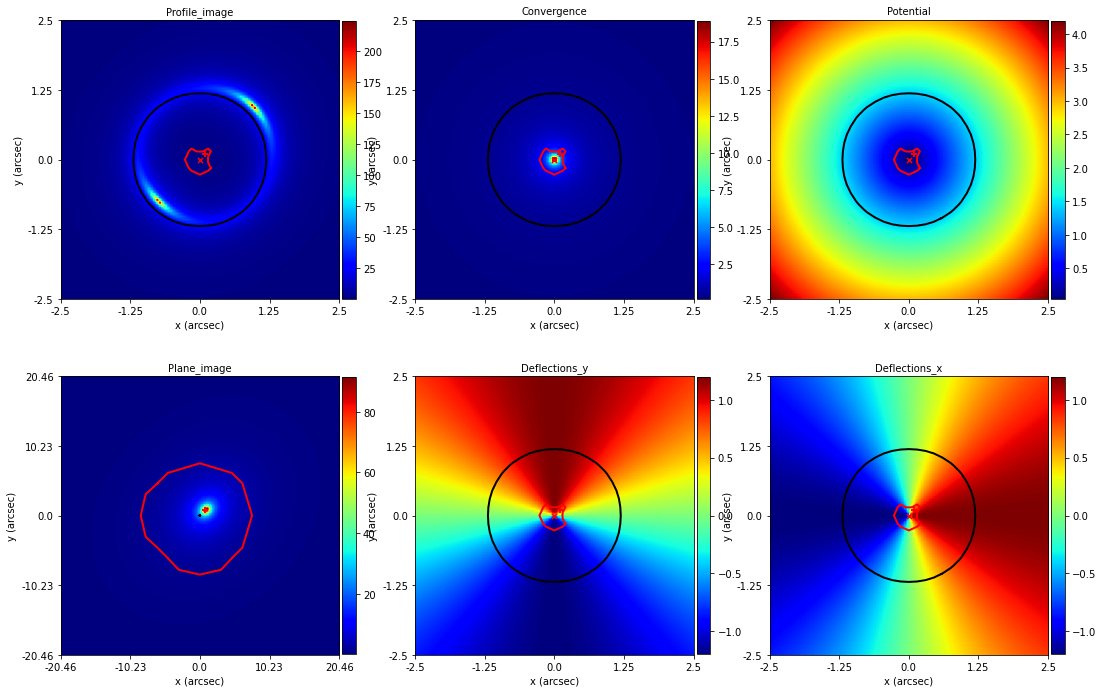

In [13]:
# simulated image
aplt.tracer.subplot_tracer(tracer=tracer, grid=grid)

### Second method

In [7]:
# for second option, importing necessities and defining mass-sheet class

import numpy as np
from astropy import cosmology as cosmo

import autofit as af
from autoarray.structures import arrays, grids
from autoastro import dimensions as dim
from autoastro.profiles import geometry_profiles
from autoastro.profiles import mass_profiles as mp


class MassSheet(geometry_profiles.SphericalProfile, mp.MassProfile):
    @af.map_types
    def __init__(self, centre: dim.Position = (0.0, 0.0), kappa: float = 0.0):
        """
        Represents a mass-sheet
        Parameters
        ----------
        centre: (float, float)
            The (y,x) arc-second coordinates of the profile centre.
        kappa : float
            The magnitude of the convergence of the mass-sheet.
        """
        super(MassSheet, self).__init__(centre=centre)
        self.kappa = kappa

    def convergence_func(self, grid_radius):
        return 0.0

    @grids.convert_coordinates_to_grid
    def convergence_from_grid(self, grid):
        return grid.mapping.array_stored_1d_from_sub_array_1d(
            sub_array_1d=np.full(shape=grid.sub_shape_1d, fill_value=self.kappa)
        )

    @grids.convert_coordinates_to_grid
    def potential_from_grid(self, grid):
        return grid.mapping.array_stored_1d_from_sub_array_1d(
            sub_array_1d=np.zeros(shape=grid.sub_shape_1d)
        )

    @grids.convert_coordinates_to_grid
    @geometry_profiles.transform_grid
    @geometry_profiles.move_grid_to_radial_minimum
    def deflections_from_grid(self, grid):
        grid_radii = self.grid_to_grid_radii(grid=grid)
        return self.grid_to_grid_cartesian(grid=grid, radius=self.kappa * grid_radii)

    @property
    def is_mass_sheet(self):
        return True


In [19]:
# for second option

ms = MassSheet((0.0,0.0), 0.5)
ms.convergence_from_grid(grid)

#TASK: work on plot method

Array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])